In [256]:
import sys 
sys.path.append(r'/Users/asbjornfyhn/Desktop/Python/Library')
from ChartGenerator import PlotGenerator
import pandas as pd, yfinance as yf
from matplotlib import pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
# Define the ticker list
indicies = ['^GSPC','^SPXEW']
# Create empty list of dataframes 
df_list = []
# Loop through tickers
for ticker in indicies:
    # Download the data
    data = yf.download(ticker)
    # Add a symbol column
    data['Symbol'] = ticker
    # Add data to df_list
    df_list.append(data)
# Concatenate df_list
df = pd.concat(df_list)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [88]:
# Replace the ticker with the name
df.replace({'^GSPC':'S&P 500','^SPXEW':'S&P 500 Equal Weight'},inplace=True)
# Reset the index
df.reset_index(inplace=True)
# Convert the date to datetime
df['Date'] = pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d'))

# loc the date to be greater than the min date
min_date = df.groupby('Symbol')['Date'].min().max()
df_norm = df.loc[df['Date']>=min_date]


In [89]:
# Normalize the Adj Close by the same date 
df_norm['Adj Close'] = df_norm.groupby('Symbol')['Adj Close'].transform(lambda x: x/x.iloc[0])

# pivot the dataframe
df_norm = df_norm.pivot(index='Date',columns='Symbol',values='Adj Close')

# Only have last observation for each month 
df_norm = df_norm.resample('M').last()

# Reset the index
df_norm.reset_index(inplace=True)

# Calculate the difference between the two
df_norm['Spread'] = df_norm['S&P 500'] - df_norm['S&P 500 Equal Weight']


/var/folders/yb/hc1k3b754099lzy1_y8dq0xc0000gn/T/ipykernel_30132/188545227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_norm['Adj Close'] = df_norm.groupby('Symbol')['Adj Close'].transform(lambda x: x/x.iloc[0])


In [307]:
# Calculate the 12 forward return 
df_norm['12m Forward Return SP500'] = df_norm['S&P 500'].pct_change(12).shift(-12)
df_norm['12m Forward Return SP500 EW'] = df_norm['S&P 500 Equal Weight'].pct_change(12).shift(-12)
# Calculate the 12 forward return 
df_norm['6m Forward Return SP500'] = df_norm['S&P 500'].pct_change(12).shift(-6)
df_norm['6m Forward Return SP500 EW'] = df_norm['S&P 500 Equal Weight'].pct_change(6).shift(-6)


In [369]:
# Scatter the spread against the 12m forward return
pg = PlotGenerator(height=6, width=9)

Slope: -0.12, Intercept: 0.06, R-Squared: 0.01,P-Value: 0.31, Standard Error: 0.12
['S&P 500', 'S&P 500 Equal Weight']
(-0.496797788543662, 0.5863804365175489)
Slope: 0.22, Intercept: 0.12, R-Squared: 0.01,P-Value: 0.13, Standard Error: 0.14
['S&P 500', 'S&P 500 Equal Weight']
(-0.54110581355759, 0.835157531781053)


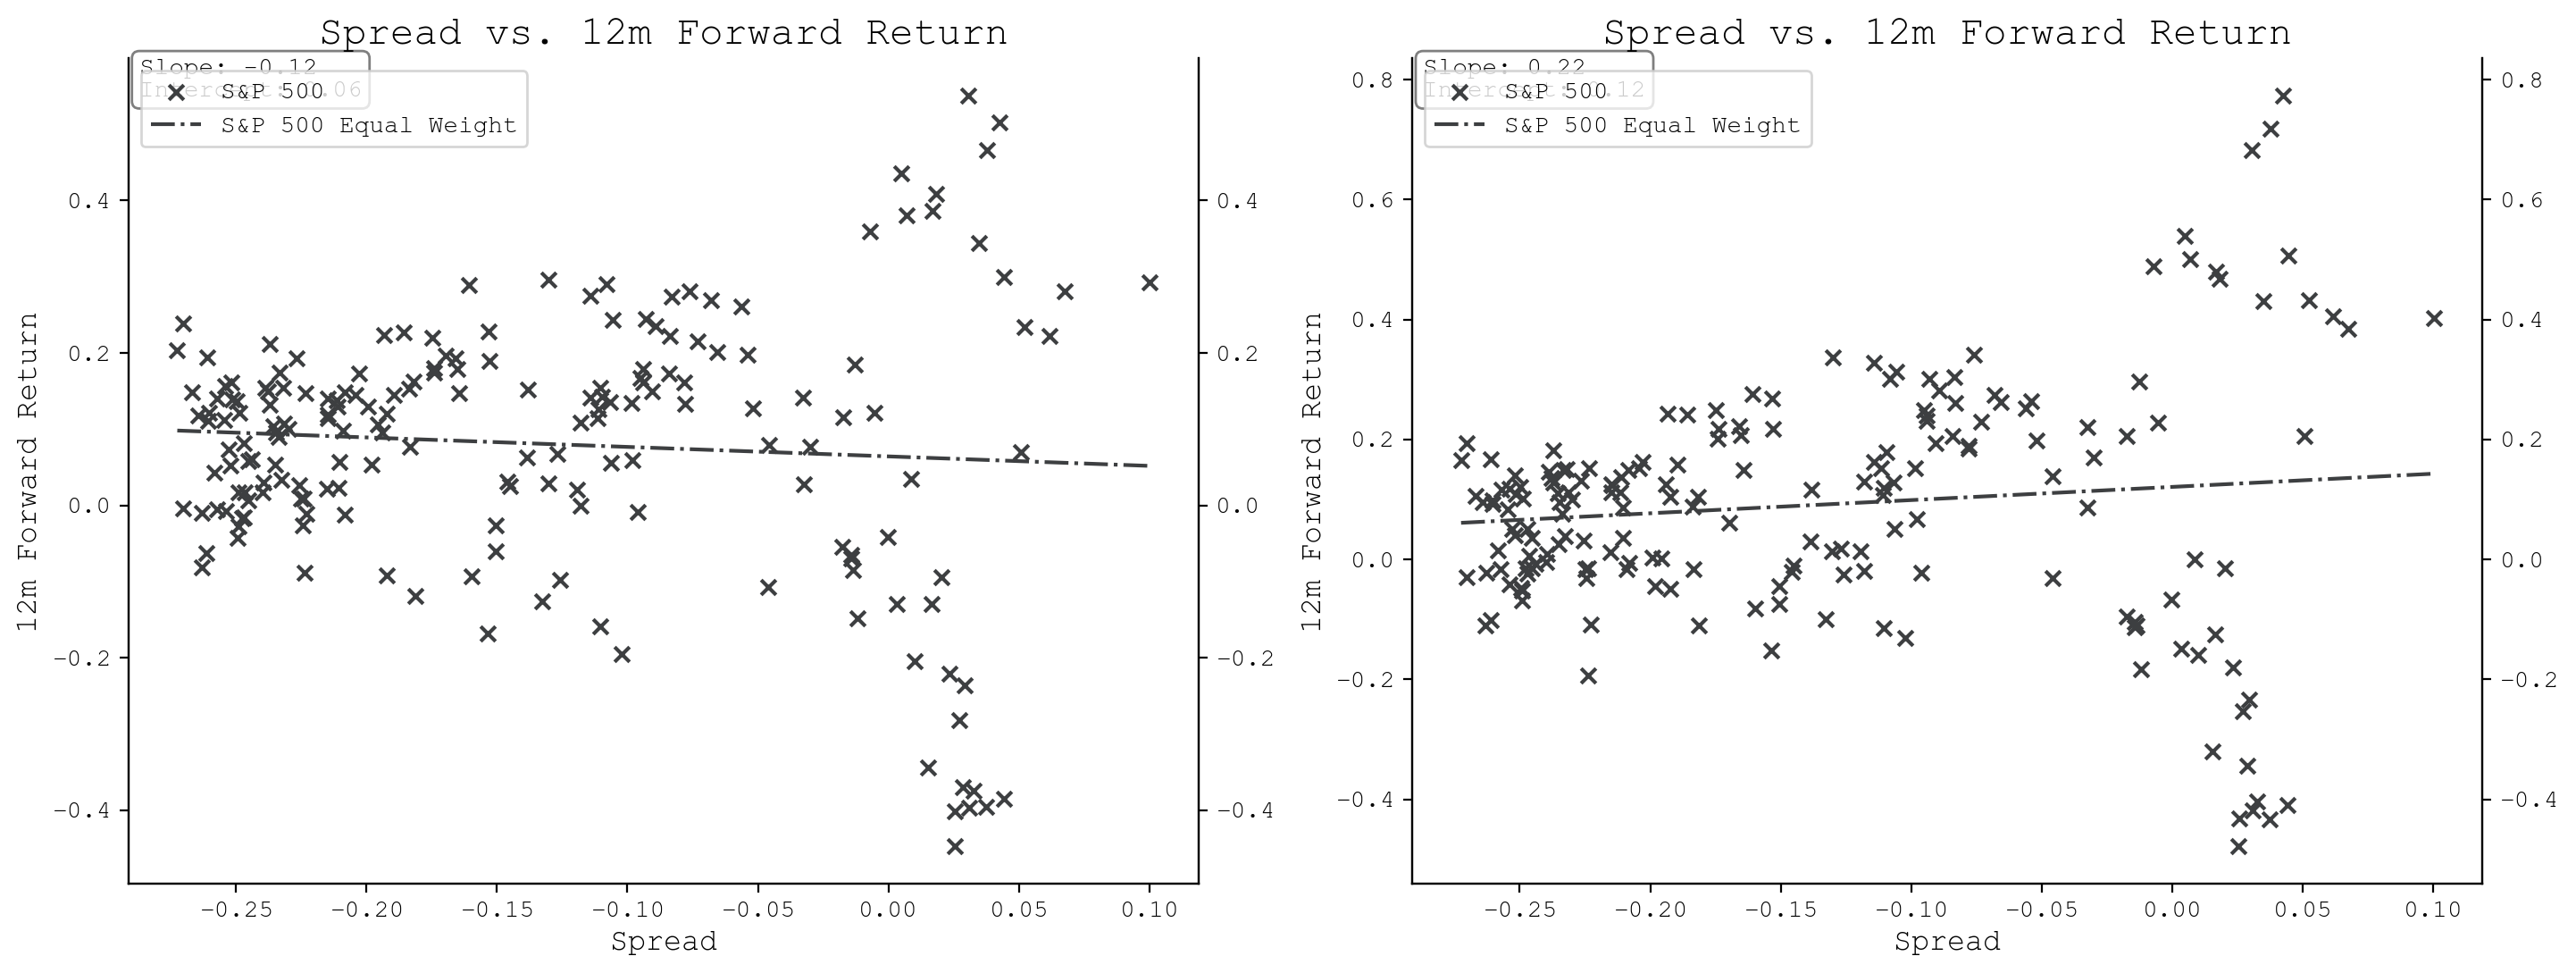

In [404]:
fig, axs = plt.subplots(1,2,figsize=(17,6))
pg.scatterplot(df = df_norm,x='Spread',y='12m Forward Return SP500',
                     xlabel='Spread',ylabel='12m Forward Return',
                     title='Spread vs. 12m Forward Return',
                     trendline='ols',
                        label=['S&P 500','S&P 500 Equal Weight'],
                                                  **{'marker':'x'},
                                                  axs=axs[0],
                                                  return_ax=False)

pg.scatterplot(df = df_norm,x='Spread',y='12m Forward Return SP500 EW',
                     xlabel='Spread',ylabel='12m Forward Return',
                     title='Spread vs. 12m Forward Return',
                     trendline='ols',
                        label=['S&P 500','S&P 500 Equal Weight'],
                                                  **{'marker':'x'},
                                                  axs=axs[1],
                                                  return_ax=False)
plt.show()

6m Forward Return S&P 500
(-49.679778854366205, 58.6380436517549)


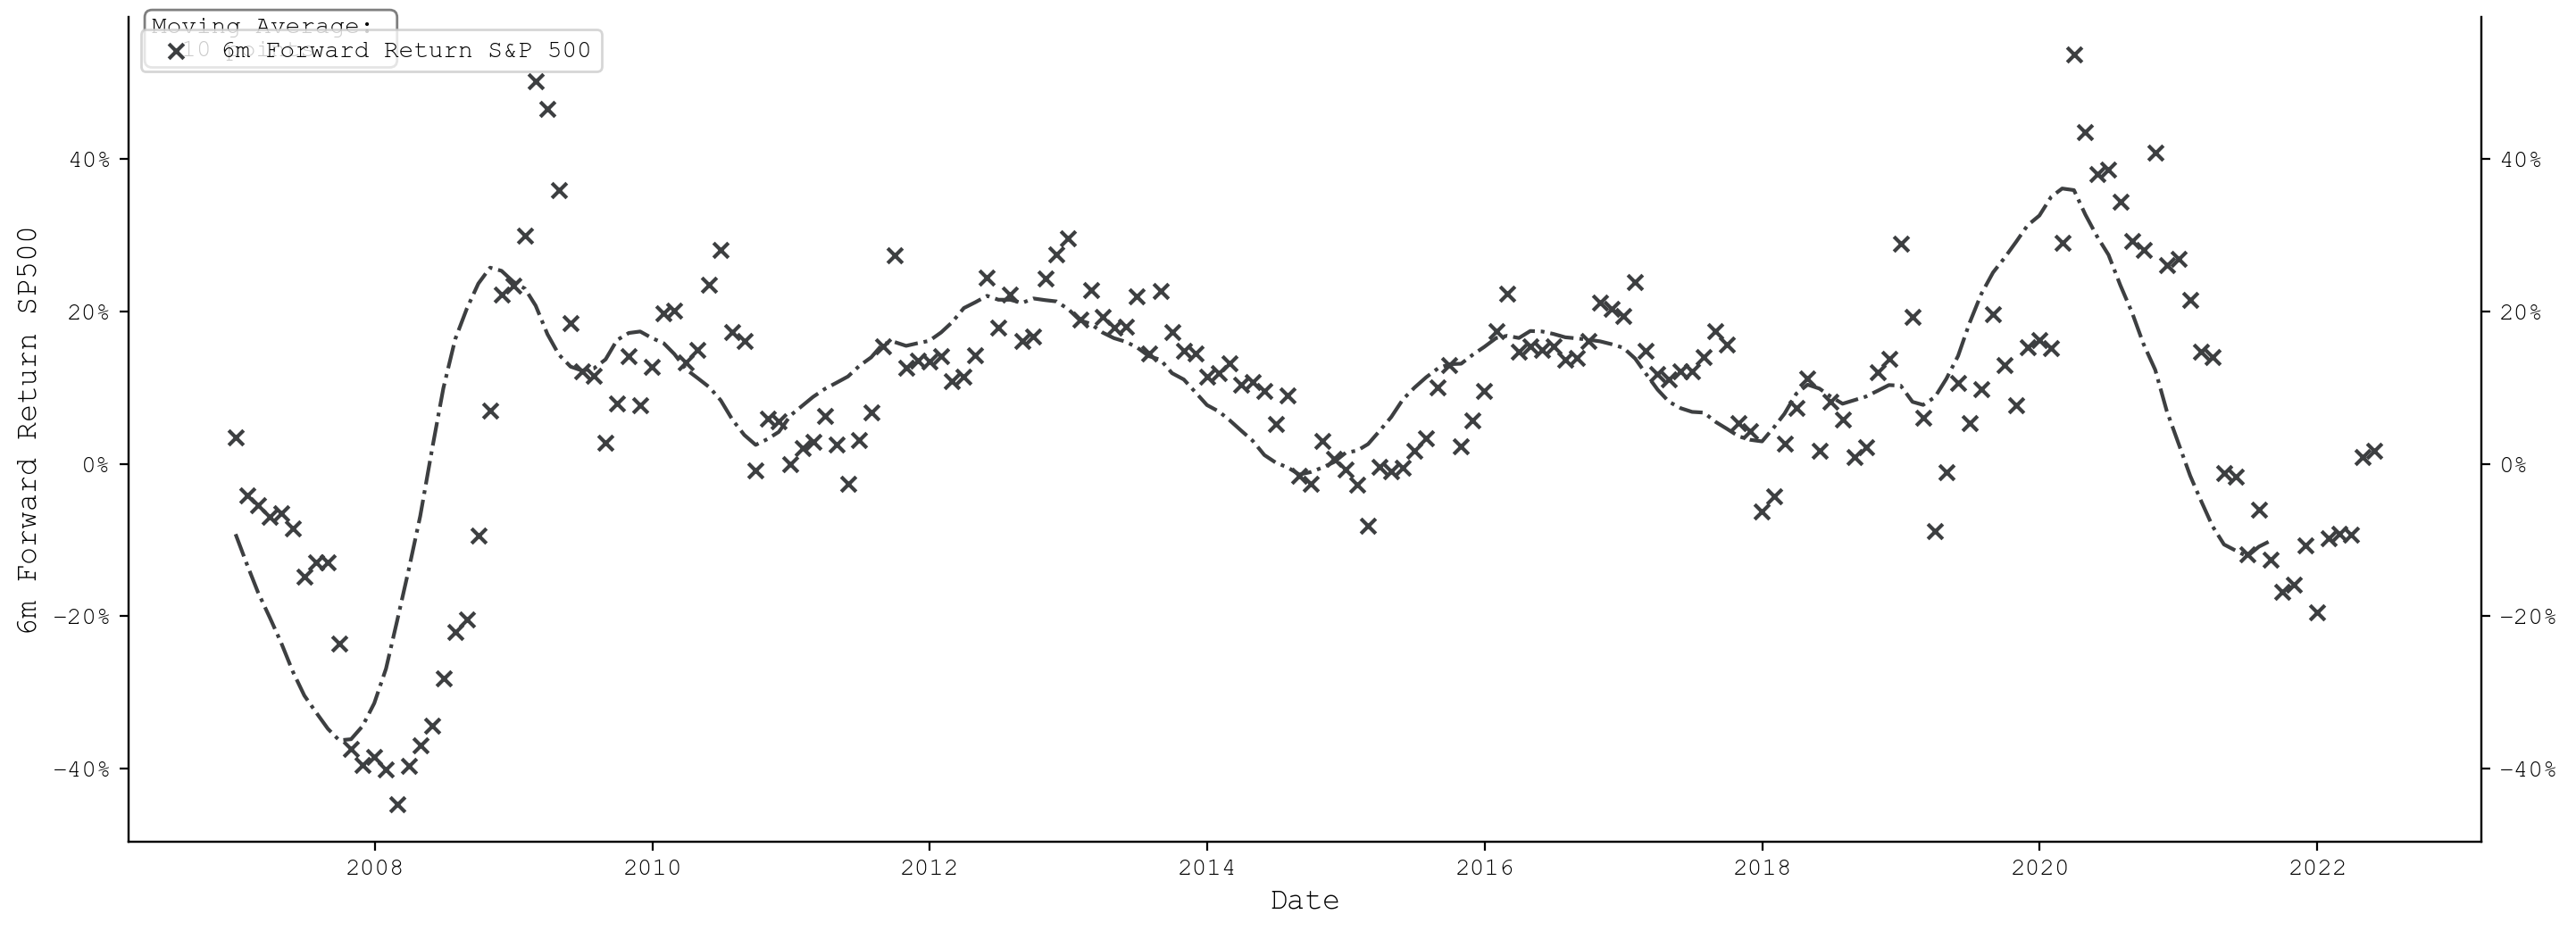

In [403]:
fig, ax = plt.subplots(figsize=(17,6))
pg.scatterplot(df = df_norm,x='Date',y='6m Forward Return SP500',
                        label='6m Forward Return S&P 500',
                                                  trendline='moving average',**{'marker':'x'},percentage=True,
                                                  axs = ax
                                                  )
plt.show()